In [1]:
import torch

# 1. Define a device variable. If a GPU is available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_devices)

    # Get information about the current device
    current_device_id = torch.cuda.current_device()
    print("Current device ID:", current_device_id)

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device_id)
    print("Device name:", device_name)

    # Get detailed device properties
    device_props = torch.cuda.get_device_properties(current_device_id)
    print("Device properties:", device_props)

    # Get memory information
    memory_allocated = torch.cuda.memory_allocated(current_device_id)
    memory_reserved = torch.cuda.memory_reserved(current_device_id)
    print("Memory allocated:", memory_allocated)
    print("Memory reserved:", memory_reserved)
else:
    print("CUDA is not available.")

Using device: cuda
Number of CUDA devices: 1
Current device ID: 0
Device name: NVIDIA RTX A4000
Device properties: _CudaDeviceProperties(name='NVIDIA RTX A4000', major=8, minor=6, total_memory=16108MB, multi_processor_count=48)
Memory allocated: 0
Memory reserved: 0


In [2]:
!nvidia-smi

Mon Feb 17 01:35:16 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 51%   59C    P8    17W / 140W |      3MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch

In [4]:
# https://pytorch.org/docs/stable/nn.html


class Linear:
    # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)[source]
    # y = x * weight + bias
    def __init__(self, fan_in, fan_out, bias=True, device=device):
        self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5
        self.bias = torch.zeros(fan_out, device=device) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] +( [] if self.bias is None else [self.bias] )
        


In [5]:
class BatchNormId:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1, device=device):
        self.eps = eps
        self.momentum = momentum
        self.training = True # different behaviour whether you are training neural net or you are evaluating
        
        # params
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        
        # buffers
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)
        
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            if x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad(): # don't want pytorch to create computational graph for this
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
batchnorm1 = BatchNormId(100)
batchnorm1 = BatchNormId(100, device="cuda")

In [6]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [7]:
class Embedding:
    def __init__(self, num_embedding, embedding_dim):
        # num_embedding=vocab_size, embedding_dim=embedding_size
        self.weight = torch.randn((num_embedding, embedding_dim), device=device) 
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

In [8]:
class FlattenConsecutive:
    
    def __init__(self, n):
        # how many consecutive elemnts w want
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [9]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [10]:
hyperparams = {
'block_size': 8,
'embedding_size': 20,
'hidden_layer_size': 250,
'batch_size': 1024,
'learning_rates_A': 0.20,
'learning_rates_B': 0.01,
'epochs': 200000
}


block_size = hyperparams['block_size']
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}
print(stoi, itos)

vocab_size = len(itos.keys())

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(context, ix)
            #print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(Xtr.shape, Ytr.shape)
X, Y = Xtr, Ytr

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182625, 8]) torch.Size([182625])


In [11]:
print(vocab_size)

27


In [22]:
n_embed = hyperparams['embedding_size']
n_hidden = hyperparams['hidden_layer_size']
block_size = hyperparams['block_size']


model = Sequential([
    Embedding(vocab_size, n_embed), 
    FlattenConsecutive(2),  Linear(n_embed * 2, n_hidden, bias=False),  BatchNormId(n_hidden), Tanh(), 
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False),  BatchNormId(n_hidden), Tanh(), 
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False),  BatchNormId(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size) 
])

In [23]:
with torch.no_grad():
    model.layers[-1].weight *= 0.1
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

print(sum(p.nelement() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True
            

268817


In [24]:
Xtr.shape[0]

182625

In [25]:
ix = torch.randint(0, Xtr.shape[0], (32,), device=device)
x, y = Xtr[ix], Ytr[ix]
logits = model(x)

In [26]:
model.layers[0].out.shape

torch.Size([32, 8, 20])

In [27]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 20)
FlattenConsecutive : (32, 4, 40)
Linear : (32, 4, 250)
BatchNormId : (32, 4, 250)
Tanh : (32, 4, 250)
FlattenConsecutive : (32, 2, 500)
Linear : (32, 2, 250)
BatchNormId : (32, 2, 250)
Tanh : (32, 2, 250)
FlattenConsecutive : (32, 500)
Linear : (32, 250)
BatchNormId : (32, 250)
Tanh : (32, 250)
Linear : (32, 27)


In [28]:
torch.randn(32, 8, 64).mean((0,1), keepdim=True).squeeze().shape

torch.Size([64])

In [29]:
max_steps = hyperparams['epochs']
batch_size = hyperparams['batch_size']
lossi, vlossi = [], []

for layer in model.layers:
    layer.training = True
    
for i in range(max_steps):
    indexes  = torch.randint(0, X.shape[0], (batch_size, ), device=device)
    x, Y_batch = X[indexes], Y[indexes]
#    x = C[X_batch].view(-1, 30)

    # forward pass
    logits = model(x)
    loss = torch.nn.functional.cross_entropy(logits, Y_batch)

    
    # backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 10000 else 0.01
    with torch.no_grad():
        for p in model.parameters():
            p -= lr * p.grad
    

    lossi.append(loss.log10().item())
    
    if i % 1000 == 0:
        
        validation_loss = split_loss('val')
        vlossi.append(validation_loss.log10().item())
        print(f"{i}/{max_steps}: train loss = {loss.item():.3}, validation loss = {validation_loss.item():.3}")
    

0/200000: train loss = 3.3, validation loss = 3.24
1000/200000: train loss = 2.17, validation loss = 2.15
2000/200000: train loss = 2.08, validation loss = 2.09
3000/200000: train loss = 1.97, validation loss = 2.06
4000/200000: train loss = 1.89, validation loss = 2.06
5000/200000: train loss = 1.95, validation loss = 2.03
6000/200000: train loss = 1.96, validation loss = 2.02
7000/200000: train loss = 1.87, validation loss = 2.01
8000/200000: train loss = 1.81, validation loss = 2.02
9000/200000: train loss = 1.86, validation loss = 2.02
10000/200000: train loss = 1.9, validation loss = 2.01
11000/200000: train loss = 1.78, validation loss = 1.99
12000/200000: train loss = 1.77, validation loss = 1.99


KeyboardInterrupt: 

In [109]:
Y_batch

tensor([12, 12,  2, 19,  0,  5, 15, 25, 15,  1, 20,  9,  0,  0,  5,  0, 21,  1,
        13,  5,  0, 18, 15,  0,  0,  6,  9, 13, 12,  2,  0,  8],
       device='cuda:0')

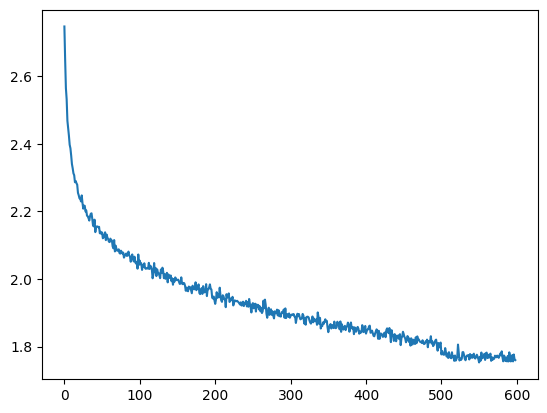

In [34]:
from matplotlib import pyplot as plt
plt.plot(10 ** torch.tensor(lossi)[:12000].view(-1, 20).mean(1)[1:])

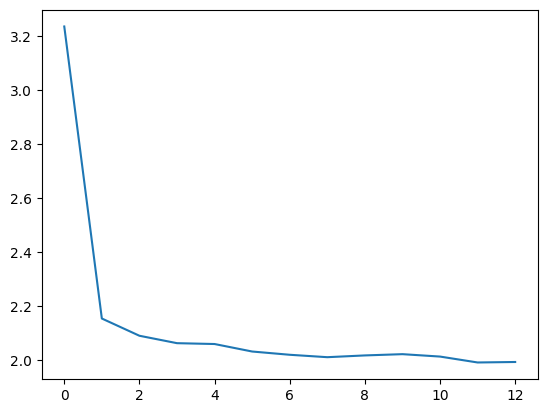

In [40]:
plt.plot(10**torch.tensor(vlossi))

In [36]:
import torch
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = torch.nn.functional.cross_entropy(logits,y)
    return loss

In [37]:
print(split_loss('train'))
print(split_loss('val'))

tensor(1.7624, device='cuda:0')
tensor(1.9939, device='cuda:0')


In [38]:
for layer in model.layers:
    layer.training = False

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = torch.nn.functional.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))


xyaire.
grick.
dusto.
jovee.
caesirh.
shenix.
hawaton.
areliz.
kiers.
layla.
evamadel.
oatie.
samanyah.
kobi.
kyziree.
laken.
khara.
arisley.
jamoni.
britt.


In [175]:
logits.shape

torch.Size([32, 27])

In [173]:
2+2

4

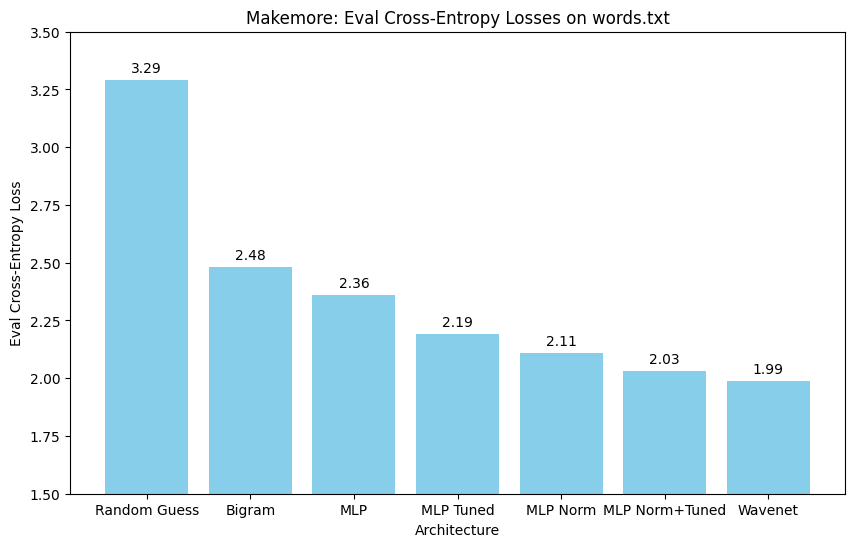

In [44]:
import matplotlib.pyplot as plt

# Names of the models/architectures
architectures = [
    "Random Guess",
    "Bigram",
    "MLP",
    "MLP Tuned",
    "MLP Norm",
    "MLP Norm+Tuned",
    "Wavenet"
]

# Their corresponding eval cross-entropy losses
losses = [3.29, 2.48, 2.36, 2.19, 2.11, 2.03, 1.99]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(architectures, losses, color='skyblue')

plt.xlabel("Architecture")
plt.ylabel("Eval Cross-Entropy Loss")
plt.title("Makemore: Eval Cross-Entropy Losses on words.txt")
plt.ylim(1.5, 3.5)

# Optionally, annotate each bar with its loss value
for bar, loss in zip(bars, losses):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{loss:.2f}', 
             ha='center', va='bottom')

plt.show()
